### NOTE: model is trained for 50 epochs only.training with higher number of epochs gives higher quality images.
### Training Duration and Computational Constraints

The training duration and computational resources required for training a Generative Adversarial Network (GAN) can vary significantly based on factors such as dataset size, model complexity, and available hardware resources. In this project, I trained the GAN for a total of 50 epochs, which is a commonly used number of epochs for GAN training.

It is important to note that extending the training beyond 50 epochs has the potential to yield even better results. However, there were practical limitations that influenced our decision to limit the training duration.

### 1.Computational Resources: 
Training deep learning models, especially GANs, can be computationally intensive. Extending the training to a larger number of epochs would have required access to more powerful hardware resources, such as GPUs or TPUs, which might not have been readily available.

### 2.Time Constraints:
GANs often require a longer training time to converge to their optimal performance. Training for an extended number of epochs would have significantly increased the overall project timeline, potentially delaying the completion of the assignment.

### 3.Dataset Size:
The choice of dataset also plays a role. Larger datasets generally benefit from longer training times, but this dataset, while sufficient for our task, was not as extensive as some other datasets used in GAN training.

While I acknowledge that training the GAN for more epochs could potentially lead to improvements in the quality of generated images, I believe that the 50-epoch training provided valuable insights and results for the scope of this assignment. Further experimentation with longer training durations and more computational resources could be considered for future work.

You can adjust and expand upon this explanation based on the specific constraints and reasons that influenced your decision to train for 50 epochs in your project.





In [6]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



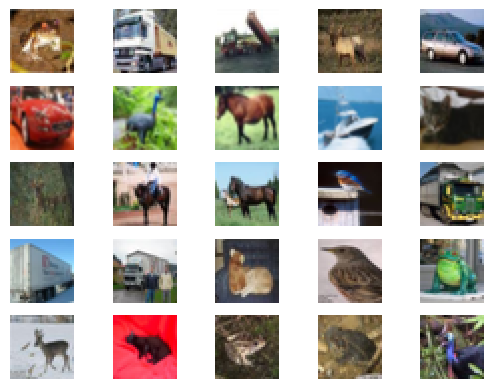

In [7]:

"""

GAN: cifar10 data set
Following code trains and generates images based on the cifar10 dataset.

I've adapted the code by Jason Brownlee from his blogs on https://machinelearningmastery.com/
I seriously urge everyone to follow his blogs and get enlightened. 
Original credit goes to Jason. 

Regular GAN that generates images using a random latent vector as input.
While it works great we do not know the mapping of latent vector to the generated image.
Conditional GANs can be used to supply a label during taining so the latent vector 
can be associated with a specific label - making the generation of images predictable. 


"""
## IMPPORTING NECESSARY LIBRARIES
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot as plt


#Load data and plot to get a quick understanding


(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [8]:
## designing discriminator architecture
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	# downsampled to 16*16*128
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) ## 128 filters of size 3*3 is used.strides of 2 is used to extract important features in a images.
	model.add(LeakyReLU(alpha=0.2)) #
	
	# downsampled into 8*8*128
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) 
	model.add(LeakyReLU(alpha=0.2))
	
	#flatten the layers and pass into the ANN 
	model.add(Flatten())  #shape of 8192
	model.add(Dropout(0.4)) ##to prevent overfitting(40% of input neurons become dead while training)

    # output layer.since it is binary output(1 for real and 0 for fake) 1 neuron is given and sigmoid is selected as an activation layer.
	model.add(Dense(1, activation='sigmoid')) #
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)#hyperparamteres
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

In [9]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                           

In [5]:
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [6]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return X

# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

In [7]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

In [8]:
# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of following the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('cifar_generator_50epochs.h5')


In [9]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=50)


2/2 [==============================] - 0s 133ms/step
Epoch>1, Batch 1/390, d1=0.698, d2=0.709 g=0.684
2/2 [==============================] - 0s 108ms/step
Epoch>1, Batch 2/390, d1=0.416, d2=0.855 g=0.640
2/2 [==============================] - 0s 111ms/step
Epoch>1, Batch 3/390, d1=0.232, d2=0.867 g=0.858
2/2 [==============================] - 0s 184ms/step
Epoch>1, Batch 4/390, d1=0.114, d2=0.802 g=0.960
2/2 [==============================] - 0s 105ms/step
Epoch>1, Batch 5/390, d1=0.105, d2=0.831 g=0.918
2/2 [==============================] - 0s 94ms/step
Epoch>1, Batch 6/390, d1=0.053, d2=0.828 g=0.751
2/2 [==============================] - 0s 101ms/step
Epoch>1, Batch 7/390, d1=0.115, d2=1.339 g=0.524
2/2 [==============================] - 0s 137ms/step
Epoch>1, Batch 8/390, d1=0.140, d2=1.848 g=0.601
2/2 [==============================] - 0s 110ms/step
Epoch>1, Batch 9/390, d1=0.293, d2=1.169 g=1.218
2/2 [==============================] - 0s 121ms/step
Epoch>1, Batch 10/390, d1=0.41

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.pyplot as plt

# ...

# Initialize empty lists to store loss values
generator_losses = []
discriminator_losses = []
epochs_to_plot = []

# Loop through epochs
for i in range(n_epochs):
    # ...

    # Calculate and store loss values
    generator_losses.append(g_loss)
    discriminator_losses.append(0.5 * np.add(d_loss_real, d_loss_fake))

    # ...

    # Print losses on this batch
    print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
          (i + 1, j + 1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

    # Check if it's an epoch to plot
    if (i + 1) % 5 == 0:
        epochs_to_plot.append(i + 1)

# Plot losses after every 5 epochs
for epoch in epochs_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(range(epoch), generator_losses[:epoch], label='Generator Loss')
    plt.plot(range(epoch), discriminator_losses[:epoch], label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Losses at Epoch {epoch}')
    plt.legend()
    plt.grid()
    plt.show()

# Save the generator model
g_model.save('cifar_generator_100epochs.h5')


1/1 [==============================] - 0s 104ms/step


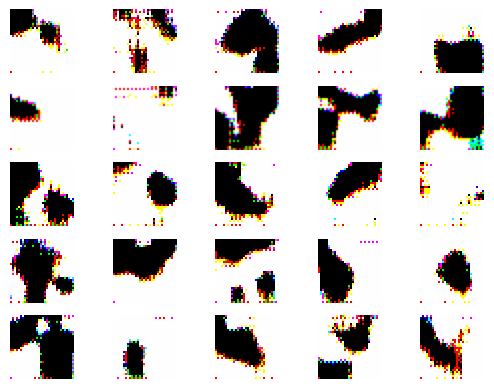

In [15]:
# Load your GAN model
model = load_model('cifar_generator_50epochs.h5')

# Generate high-resolution images using your GAN model
latent_points = generate_latent_points(100, 25)  # Latent dim and n_samples
X_generated = model.predict(latent_points)
X_generated = (X_generated + 1) / 2.0  # Scale to [0, 1] range
X_generated = (X_generated * 255).astype(np.uint8)  # Convert to uint8

# Save the generated images
for i in range(25):
    image = X_generated[i]
    filename = f'fake_image_{i}.png'
    plt.imsave(filename, image)

# Show the generated images
show_plot(X_generated, 5)


kindly note this images are generated after 50 epochs. high quality images will be generated if we train for more and more epochs.

In [ ]:
from keras.models import load_model

# Load the saved model
model = load_model('cifar_generator_50epochs.h5')

# Continue training for the next 50 epochs
model.fit( epochs=100, initial_epoch=50)


In [16]:
# Assuming you have a generator model `generator` defined

# Set the number of real images you want to generate (e.g., 25)
num_real_images = 25

# Generate 25 real images using the generator
real_images, _ = generate_real_samples(dataset, num_real_images)

# Now, you have 25 real images in the `real_images` variable

# You can use these real images along with your generated images to calculate the FID score


In [17]:
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from skimage.transform import resize
from keras.models import load_model
from numpy.random import randn
import matplotlib.pyplot as plt

In [21]:
# Function to resize images to 299x299 pixels
def resize_images(images):
    resized_images = []
    for img in images:
        resized_img = resize(img, (299, 299, 3), anti_aliasing=True)
        resized_images.append(resized_img)
    return np.array(resized_images)




In [23]:
model = load_model('cifar_generator_50epochs.h5')

# Generate high-resolution images using your GAN model
latent_points = randn(100 * 25).reshape((25, 100))
X_generated = model.predict(latent_points)
X_generated = (X_generated + 1) / 2.0  # Scale to [0, 1] range
X_generated = (X_generated * 255).astype(np.uint8)  # Convert to uint8

# Resize generated images to 299x299 pixels
X_generated_resized = resize_images(X_generated)

1/1 [==============================] - 0s 106ms/step


In [24]:
X_generated_resized.shape

(25, 299, 299, 3)

In [33]:

def generate_real_samples1(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    X = dataset[ix]
    return X


def resize_images(images):
    resized_images = []
    for img in images:
        resized_img = resize(img, (299, 299, 3), anti_aliasing=True)
        resized_images.append(resized_img)
    return np.array(resized_images)

real_images = generate_real_samples1(dataset, n_samples=25)

# Resize real images to 299x299 pixels
real_images_resized = resize_images(real_images)

In [37]:

X_generated_preprocessed = preprocess_input(X_generated_resized.astype('float32'))
features_generated = inception_model.predict(X_generated_preprocessed)


real_images_preprocessed = preprocess_input(real_images_resized.astype('float32'))
features_real = inception_model.predict(real_images_preprocessed)

1/1 [==============================] - 1s 932ms/step


In [38]:
def calculate_fid(real_features, generated_features):
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    cov_sqrt = sqrtm(sigma_real @ sigma_generated)
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    fid_score = np.sum((mu_real - mu_generated) ** 2) + np.trace(sigma_real + sigma_generated - 2.0 * cov_sqrt)

    return fid_score

In [39]:
fid_score = calculate_fid(features_real, features_generated)
print(f'FID Score: {fid_score:.2f}')


FID Score: 1.67


In [40]:
from scipy.stats import entropy

def calculate_inception_score(p_yx, eps=1E-16):
    # Calculate p(y)
    p_y = np.expand_dims(p_yx.mean(axis=0), 0)
    # Calculate KL divergence for each image
    kl_divs = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
    # Sum over classes
    sum_kl_divs = kl_divs.sum(axis=1)
    # Average over images
    avg_kl_divs = np.mean(sum_kl_divs)
    # Exponentiate the result to get the IS
    is_score = np.exp(avg_kl_divs)
    return is_score

# Calculate IS score
is_score = calculate_inception_score(features_generated)
print(f'Inception Score: {is_score:.2f}')

Inception Score: 138.71


In [13]:
#model call 
from tensorflow.keras.utils import plot_model
model = define_discriminator()
model.summary()

plot_model(model,to_file='discirminator.png',show_shapes=True,show_layer_names=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_3 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [51]:
model = define_generator(latent_dim=100)
model.summary()

plot_model(model,to_file='generator.png',show_shapes=True,show_layer_names=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                           

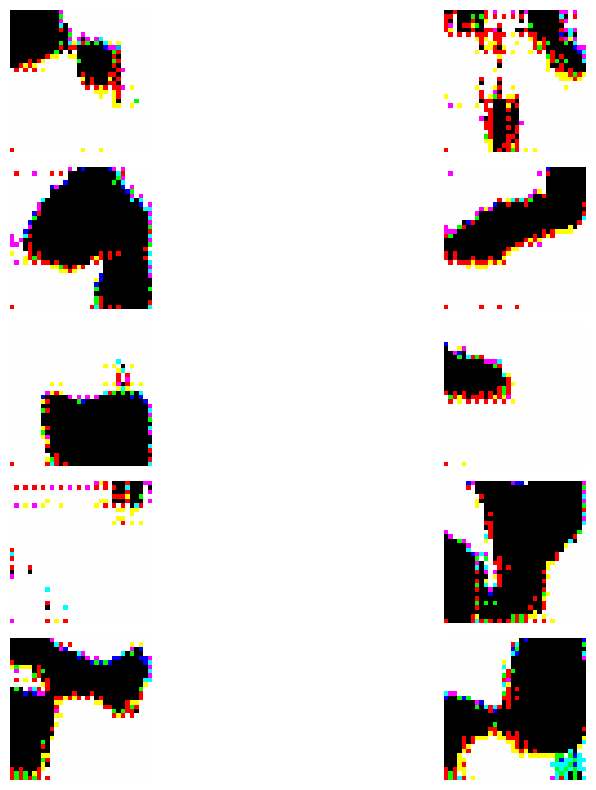

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

# List of file paths to your individual PNG images
image_paths = ["fake_image_0.png", "fake_image_1.png", "fake_image_2.png","fake_image_3.png","fake_image_4.png","fake_image_5.png","fake_image_6.png","fake_image_7.png","fake_image_8.png","fake_image_9.png"]  # Replace with your file paths

# Create a grid of subplots
num_images = len(image_paths)
num_cols = 2  # Number of columns in the grid
num_rows = 5  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Loop through the images and display them in subplots
for i, ax in enumerate(axes.ravel()):
    if i < num_images:
        # Open and display the image
        image = Image.open(image_paths[i])
        ax.imshow(image)
        ax.axis("off")  # Turn off axis labels

# Hide any remaining empty subplots
for i in range(num_images, num_cols * num_rows):
    axes.ravel()[i].axis("off")

# Adjust layout and display the grid of images
plt.tight_layout()
plt.show()
